# MNIST classification using Keras and TensorBoard

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export MODEL_DIR_ESTIMATOR_PATH=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import packages

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.backend.event_processing import event_accumulator
from absl import logging
from datetime import datetime
import os
import shutil
import numpy as np

In [3]:
tf.version.VERSION

'2.1.0'

## Import local packages

In [4]:
import utils.model_metrics  as model_metrics

In [5]:
import importlib
importlib.reload(model_metrics);

## Define paths

In [6]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except:
    print('missing PATH_TENSORBOARD')

## Define input function

In [7]:
logging.set_verbosity(logging.INFO)

In [8]:
STEPS_PER_EPOCH = 5
BATCH_SIZE = 64
NUM_EPOCHS = 5

In [9]:
def input_fn():
    datasets, ds_info = tfds.load(name='mnist', with_info=True, as_supervised=True,data_dir=data_dir)
    mnist_train, mnist_test = datasets['train'], datasets['test']

    BUFFER_SIZE = 10000
    BATCH_SIZE = 64

    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
    
        return image, label[..., tf.newaxis]

    train_data = mnist_train.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_data.repeat()

## Build a model

In [10]:
def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02),
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [11]:
model = make_model()

optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, epsilon=1e-07)

model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                346176    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

## Setup TensoBoard

In [13]:
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200323-201129


In [14]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print(i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

20200323-201129


In [15]:
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      profile_batch = 
                                                      3,write_graph=True)

In [16]:
log_dir

'/Users/tarrade/tensorboard/20200323-202154'

In [17]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard  --logdir   {log_dir}

## Train the model

In [18]:
model.fit(input_fn(),
          steps_per_epoch=5,
          epochs=10,
          callbacks=[tensorboard_callback],
          verbose =1)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/tarrade/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/mnist/3.0.0


Train for 5 steps
Epoch 1/10
5/5 [==============================] - 2s 377ms/step - loss: 1.4385 - accuracy: 0.5562
Epoch 2/10
5/5 [==============================] - 0s 23ms/step - loss: 0.7084 - accuracy: 0.8219
Epoch 3/10
5/5 [==============================] - 0s 26ms/step - loss: 0.4785 - accuracy: 0.8875
Epoch 4/10
5/5 [==============================] - 0s 32ms/step - loss: 0.4224 - accuracy: 0.8906
Epoch 5/10
5/5 [==============================] - 0s 24ms/step - loss: 0.3704 - accuracy: 0.9125
Epoch 6/10
5/5 [==============================] - 0s 25ms/step - loss: 0.4121 - accuracy: 0.9031
Epoch 7/10
5/5 [==============================] - 0s 31ms/step - loss: 0.2842 - accuracy: 0.9375
Epoch 8/10
5/5 [==============================] - 0s 29ms/step - loss: 0.3232 - accuracy: 0.9000
Epoch 9/10
5/5 [==============================] - 0s 28ms/step - loss: 0.3211 - accuracy: 0.9031
Epoch 10/10
5/5 [==============================] - 0s 22ms/step - loss: 0.2245 - accuracy: 0.9375


## Explore output files from TensorBoard

In [19]:
def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [20]:
print('let inspect events.out.tfevents.* files')
history_train=load_data_tensorboard(log_dir+'/train')

let inspect events.out.tfevents.* files


In [21]:
history_train

{'epoch_accuracy': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([0.55624998, 0.82187498, 0.88749999, 0.890625  , 0.91250002,
         0.90312499, 0.9375    , 0.89999998, 0.90312499, 0.9375    ])),
 'epoch_loss': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([1.43854618, 0.70838302, 0.47849739, 0.42240018, 0.37039864,
         0.41209292, 0.2841872 , 0.32315168, 0.32106024, 0.22445177]))}

In [22]:
print(history_train.keys())

dict_keys(['epoch_accuracy', 'epoch_loss'])


Loss:
  - loss [training dataset]: 0.224

Accuracy:
  - accuracy [training dataset]: 93.75%


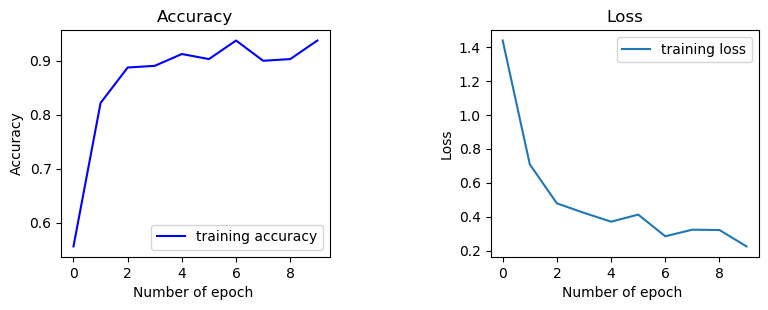

In [23]:
model_metrics.plot_acc_loss(history_train['epoch_loss'][0],history_train['epoch_loss'][1],
                            history_train['epoch_accuracy'][0],history_train['epoch_accuracy'][1])